# Solving $BeH_2$ Molecule's Ground Energy using Kandala's reduction and REM

This tutorial will demonstrate how to find the ground energy of the $BeH_2$ molecule at a specific bond distance using the reduced Hamiltonian obtained from Kandala's reduction procedure, as explained in [the provided reference](https://www.nature.com/articles/nature23879#citeas). Additionally, we will implement an error mitigation method developed by Lolur et al., as described in [their published paper](https://pubs.acs.org/doi/pdf/10.1021/acs.jctc.2c00807).

Kandala's method reduces the Hamiltonian of the $BeH_2$ molecule from 10 to 6 qubits, while the REM method reduces noise using a reference state. For a more comprehensive understanding of Kandala's procedure, we recommend referring to the "Solving the Ground Energy of 𝐵𝑒𝐻2 in small QPU using a reduction method" [tutorial](./Solving-BeH2-with-Kandala-et-al.ipynb).

<hr>


## Content

1. [Import the generated Hamiltonian obtained using Kandala's method](#001)
1. [Ansatz](#002)
1. [VQE](#003)
1. [REM](#004)


### Imports

In [2]:
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator, Options

import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# Import Qiskit Nature libraries
from qiskit_nature.second_q.algorithms import VQEUCCFactory, GroundStateEigensolver

from qiskit_nature.second_q.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.circuit.library import UCC, UCCSD
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

from qiskit_nature.settings import settings
settings.dict_aux_operators = True

In [4]:
from qiskit.opflow import  I, X, Y, Z
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit import QuantumCircuit, ParameterVector

<hr>

<a id="001"></a> 
## Read the Hamiltonian of the $BeH_2$ from file

Kandala's reduction method is utilized to derive this Hamiltonian, and the associated files are produced using the code outlined in the provided [notebook](./generating-BeH2-reduced-hamiltonians.ipynb.ipynb) titled "generating-BeH2-reduced-hamiltonians.ipynb".

In [5]:
# Define the coefficients and Pauli words

lines = None

with open('BeH2-d1.326.txt') as f:
    lines = [line.rstrip() for line in f]

paulis = []
coeffs = []

for i in range(0, len(lines), 2):
    paulis.append(lines[i])
    coeffs.append(float(lines[i+1]))

# -----------------
    
ops = []

for coeff, pauli in zip(coeffs, paulis):
    if pauli[0] == 'I':
        op = I
    elif pauli[0] == 'X':
        op = X
    elif pauli[0] == 'Y':
        op = Y
    elif pauli[0] == 'Z':
        op = Z

    for p in pauli[1:]:
        if p == 'I':
            op = op ^ I
        elif p == 'X':
            op = op ^ X
        elif p == 'Y':
            op = op ^ Y
        elif p == 'Z':
            op = op ^ Z
    
    op = coeff * op
    ops.append(op)

kandala_ops = sum(ops)

<hr>

<a id="002"></a> 
## Ansatz

This ansatz has been optimized for hardware efficiency and is based on the work of Kandala et al.

In [6]:
# Define the Ansatz
ansatz = QuantumCircuit(6)
params = ParameterVector('theta', length=30)
it = iter(params)

for _ in range(6):
    ansatz.rx(next(it), _)
    ansatz.rz(next(it), _)

ansatz.cx(0, 1)
ansatz.cx(1, 2)
ansatz.cx(2, 3)
ansatz.cx(3, 4)
ansatz.cx(4, 5)

for _ in range(6):
    ansatz.rz(next(it), _)
    ansatz.rx(next(it), _)
    ansatz.rz(next(it), _)

<hr>

<a id="003"></a>
## Start VQE 

In [7]:
from qiskit import Aer, IBMQ, QuantumCircuit
from qiskit.primitives import Estimator
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance

# Import Qiskit libraries for VQE
from qiskit.algorithms import MinimumEigensolverResult, VQE
from qiskit.algorithms.optimizers import SLSQP, SPSA, GradientDescent
from qiskit.circuit.library import EfficientSU2

In [8]:
from qiskit.primitives import Estimator, BackendEstimator
from qiskit.utils import algorithm_globals
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Estimator, Session

from qiskit.providers.fake_provider import FakeGuadalupe
from qiskit_aer.noise import NoiseModel


In [9]:
import numpy as np

In [10]:
TOKEN = ''

## Define Circuits

In [14]:
QiskitRuntimeService.save_account(channel='ibm_quantum',                            
                                  token = TOKEN,
                                  overwrite=True)
service = QiskitRuntimeService()

# Import FakeBackend
fake_backend = FakeGuadalupe()
noise_model = NoiseModel.from_backend(fake_backend)

# Set options to include noise_model
options = Options(simulator={
    "noise_model": noise_model,
    "seed_simulator": 10,
}, optimization_level=2, resilience_level=2)


# For REM
global rem_measurement
global rem_params
global evaluation
evaluation = 0
rem_measurement = None
rem_params = None

# Define evaluate_expectation function
def evaluate_expectation(params):
    global rem_measurement
    global rem_params, evaluation
    
    with Session(service=service, backend="ibmq_qasm_simulator") as session:
        estimator = Estimator(session=session, options=options)
        
        job = None
        while job is None:
            try:
                job = estimator.run(circuits=[ansatz], observables=[kandala_ops], parameter_values=[params])
            except KeyboardInterrupt:
                print ('KeyboardInterrupt : Stopping the VQE')
                raise(KeyboardInterrupt)
            except:
                print('Job failed, retrying...')
    
    result = job.result()
    
    evaluation += 1
    
    f = open("kandala_sim_out.txt", "a")
    f.write(np.array2string(np.array(params)))
    f.write('/n')
    f.write(str(np.real(result.values[0])))
    f.write('----/n')
    f.close()
    
    # Using the first guess as the REM reference.
    if rem_measurement is None:
        rem_params = params  # Storing the reference parameters
        
        # Computing and storing the rem measurement
        rem_measurement = result.values[0]
        
        # For convinience.
        print('Init REM')
        print(rem_params)
        print(rem_measurement)
        print('----')
    
    # Pass results back to callback function
    return result.values[0]

def callback(x,fx,ax,tx,nx): # nx
    # Callback function to get a view on internal states and statistics of the optimizer for visualization
    global iteration, history
    iteration += 1
    
    history.append({'evaluations': x,
                    'parameters': fx,
                    'cost' : ax,
                    'energy': ax,
                    'stepsize': tx,
                    'accepted': nx})
 
    print(f'iteration : {iteration}')
    #print(f'the number of function evaluations : {x},\n the parameters : {fx},\n the function value : {ax}, the stepsize : {tx}, whether the step was accepted : {nx}')
    print(f'{fx} \n{ax}')

np.random.seed(10)

# Define initial point. We shall define a random point here based on the number of parameters in our ansatz
initial_point = np.random.random(30)*np.pi*2

optimizer =  SPSA(maxiter=200, callback=callback)

global iteration
iteration = 0
global history
history = []

# optimizer = GradientDescent(maxiter=100, callback=callback)

# Define minimize function
result =  optimizer.minimize(evaluate_expectation, x0=initial_point)


Init REM
[ 5.04635053  0.33038834  4.18132928  4.90487355  2.93221194  1.61243898
  1.44446568  4.5785554   1.26255472  0.75505542  4.10624274  5.79034706
 -0.17519231  3.0181989   4.90584809  4.04861478  4.33492241  2.03391142
  5.56654488  4.68981206  3.6089068   1.09328075  2.54576918  4.03570643
  2.57611971  2.92699035  4.0815444   3.42414267  4.28656602  3.97643912]
0.09737471888451357
----
iteration : 1
[ 3.7250503   1.25168858  5.10262952  5.82617379  4.25351217  2.53373922
  0.12316545  3.65725516 -0.05874551  1.67635566  3.1849425   7.1116473
  1.14610793  4.33949914  6.22714832  2.72731455  3.41362217  2.95521166
  6.88784512  5.6111123   4.53020704 -0.22801948  1.22446894  3.11440619
  3.89741995  3.84829058  5.00284464  2.10284243  5.20786625  4.89773936] 
-0.004082669855458215
iteration : 2
[ 4.26046064  0.71627823  4.56721917  5.29076344  4.78892252  3.06914956
 -0.4122449   3.12184481  0.47666483  1.14094531  2.64953216  7.64705765
  0.61069758  4.87490949  6.76255867  

KeyboardInterrupt: 

In [15]:
Energy_H_t = [np.real(it['energy']) for it in history]
print("Last VQE Energy:", Energy_H_t[-1])
print("Mean VQE Energy (last 10):", np.mean(Energy_H_t[-10:]))

Last VQE Energy: -2.774383021106145
Mean VQE Energy (last 10): -2.7749288826627234


In [18]:
real_solution_t = -2.99
print('Reference energy : ', real_solution_t)

Reference energy :  -2.99


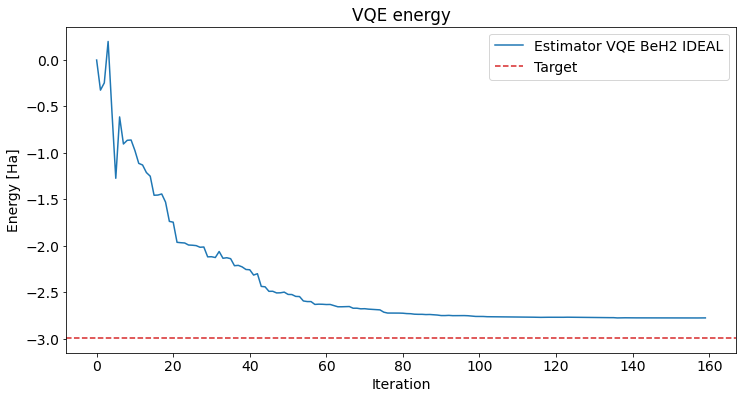

In [19]:
plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(Energy_H_t, label="Estimator VQE BeH2 IDEAL")
plt.axhline(y=real_solution_t.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [Ha]")
plt.title("VQE energy")
plt.show()

<hr>

<a id="004"></a>
## REM

Within this code section, we will integrate an error mitigation procedure into the previously described method. The REM method has the benefit of minimal post-processing and generally necessitates only one or no additional measurements.

Briefly, the reference-state error mitigation (REM), relies on postprocessing that can be readily performed on a classical computer. The REM method rests on an appropriate choice of a reference wave function, or reference
state. 

In [23]:
from qiskit_aer import AerSimulator, StatevectorSimulator
from qiskit_ibm_runtime.options import ExecutionOptions

ref_backend = Aer.get_backend("statevector_simulator")
ref_estimator = BackendEstimator(backend=ref_backend)

def compute_ref_energy(ref_params):
    job = ref_estimator.run(circuits=[ansatz], observables=[kandala_ops], parameter_values=[ref_params])

    result = job.result()

    return result.values[0]
 

In [24]:
print(rem_params)
print(rem_measurement)

[ 5.04635053  0.33038834  4.18132928  4.90487355  2.93221194  1.61243898
  1.44446568  4.5785554   1.26255472  0.75505542  4.10624274  5.79034706
 -0.17519231  3.0181989   4.90584809  4.04861478  4.33492241  2.03391142
  5.56654488  4.68981206  3.6089068   1.09328075  2.54576918  4.03570643
  2.57611971  2.92699035  4.0815444   3.42414267  4.28656602  3.97643912]
0.09737471888451357


In [25]:
E_refs = []

for i in range(100):
    E_refs.append(np.real(compute_ref_energy(rem_params)))
    if (i+1) % 10 == 0:
        print(i+1)

E_ref = np.mean(E_refs)

delta_e_rem = np.real(E_ref - rem_measurement)
print('Delta E =', delta_e_rem)

10
20
30
40
50
60
70
80
90
100
Delta E = -0.05062904311058996


In [26]:
rem_energy = [np.real(e + delta_e_rem) for e in Energy_H_t]

In [27]:
print("Mean VQE REM Energy (last 10):", np.mean(rem_energy[-10:]))

Mean VQE REM Energy (last 10): -2.825557925773313


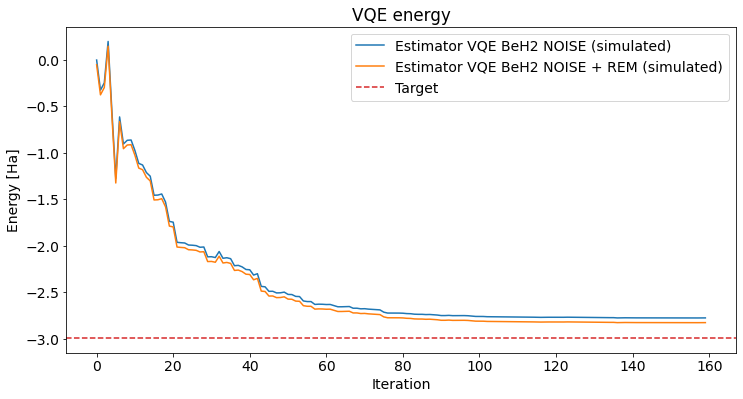

In [28]:
plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(Energy_H_t, label="Estimator VQE BeH2 NOISE (simulated)")
plt.plot(rem_energy, label="Estimator VQE BeH2 NOISE + REM (simulated)")
plt.axhline(y=real_solution_t.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [Ha]")
plt.title("VQE energy")
plt.show()

In [1]:
computed_total_shift = -12.599259940427942